# 🛠️ Building the Tool Agent Pattern from Scratch in AI Agents

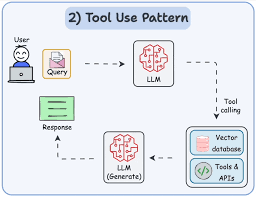

This notebook focuses on the Tool Agent Pattern—a foundational approach in AI agent design where the agent interacts with external tools, APIs, or functions to complete tasks it cannot solve through reasoning alone. Instead of being a standalone problem solver, the agent becomes an orchestrator that decides when and how to use available tools to achieve its goal.

This pattern underpins many recent agent frameworks, such as LangChain, LangGraph, and OpenAI's Function Calling, and is a key ingredient in systems like AutoGPT, Toolformer, and ReAct.

## 🔍 What You'll Learn:
   #### How to build a tool-using agent from scratch
   #### How to design and register tools for agent access
   #### How the agent chooses and invokes the right tool based on natural language prompts and goals
   #### How tool invocation fits into the reasoning + action cycle

In [ ]:
import re
import json

## Upload the LLM API

In [ ]:
from Utils.utils import llm

# create  functions (tools)

these functions are the tools that llm could use to generate a better awnser.
the doc string of each function should be very describable of the function purpose and its arguments for llm to understand it and call it with right argument.

In [ ]:
#thoes are imagenary factors that don't mean nothing just to proove that the agent is using those function to generate the awnser
def calculate_phynx_factor(a: int, b: int) -> int:
    """
    Compute the 'phynx factor' for two integer inputs.

    The phynx factor is defined as the square of the product of `a` and `b`.
    Mathematically: phynx_factor = (a * b)²

    Parameters:
        a (int): The first input integer.
        b (int): The second input integer.

    Returns:
        int: The computed phynx factor.
    """
    print(f"--- TOOL: Calculating phynx factor for {a} and {b} ---")
    return (a * b) ** 2


def xex_factor(a:int , b:int) -> float:
    """
    Compute the 'xex factor' for two integer inputs.

    The xex factor is defined as the square of the product of `a` and `b`.
    Mathematically: xexf actor = (a + b) / 20

    Parameters:
        a (int): The first input integer.
        b (int): The second input integer.

    Returns:
        int: The computed xex factor.
    """
    print(f"--- TOOL: Calculating xex factor for {a} and {b} ---")
    
    return (a + b) / 20



## Creating the system prmpt

In [67]:
systeme_prompt = '''
You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags. 
You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug 
into functions. Pay special attention to the properties 'types'. You should use those types as in a Python dict. 
For each function call return a json object with function name and arguments within <tool_call></tool_call> ,your awnser should contain only the tool call as follows:

begin
<tool_call>
{"name": <function-name>,"arguments": <args-dict>}
</tool_call>
end

Here are the available tools:

<tools> {
    "name": "calculate_phynx_factor",
    "description": '
    Compute the 'phynx factor' for two integer inputs.

    The phynx factor is defined as the square of the product of `a` and `b`.
    Mathematically: phynx_factor = (a * b)²

    Parameters:
        a (int): The first input integer.
        b (int): The second input integer.

    Returns:
        int: The computed phynx factor.
    ',
    "parameters": {
        "properties": {
            "a": {
                "type": "int"
            },
            "b": {
                "type": "int"
            }
        }
    }
},
{
    "name": "xex_factor",
    "description": 'this function calculate the xex factor',
    "parameters": {
        "properties": {
            "a": {
                "type": "int"
            },
            "b": {
                "type": "int"
            }
        }
    }
}
</tools>
'''

llm_history = [
    {
        'role' : 'system',
        'content' : systeme_prompt
    },
    {
        'role' : 'user',
        'content' : 'what is the result of 1 and 50 using the sphynx factor'
    }
]

## ask the LLM to choose witch tool it need to generate the awnser

In [ ]:
#llm call
llm_call = llm(llm_history[0]['content'] + llm_history[1]['content']) 

In [69]:
llm_call

'begin\n<tool_call>\n{"name": "calculate_phynx_factor", "arguments": {"a": 1, "b": 50}}\n</tool_call>\nend\n'

## turn the llm call into function calls 

In [ ]:
def parser(llm_response):
    '''this function uses take as an argument the llm responce and parse it to call the function'''

    #clean the llm_responce
    pattern = r'</?(tool_call)> ?'
    clean_tags = re.sub(pattern, '', llm_response)
    clean_tags = clean_tags.replace('begin','')
    clean_tags = clean_tags.replace('end', '')
    clean_tags = clean_tags.replace('\n','')

    #turn the call in to json object
    llm_call = json.loads(clean_tags)

    #call the function 
    func_name = llm_call['name']
    if func_name == 'calculate_phynx_factor':
        result = calculate_phynx_factor(**llm_call['arguments'])
        return {
            'result' : result
        }
    elif func_name == xex_factor:
        result = calculate_phynx_factor(**llm_call['arguments'])
        return {
            'result' : result
        }
    else :
        return {
            'result' : 'no tool was called'
        }
    #print(llm_call['arguments']['a'] + llm_call['arguments']['b'])

--- TOOL: Calculating phynx factor for 1 and 50 ---


{'result': 2500}

In [ ]:
parser(llm_call)

## awnser the user query with the help of the tool result

In [71]:
tools_result = parser(llm_call)
user_prompt = llm_history[1]['content']
llm_history.append(
    {
        'role' : 'system',
        'content' : 'use the tool result to awnser this question '
    }
)

llm_call2 = llm.generate_content(
    model='gemini-2.0-flash',
    contents=[str(llm_history[2]) + str(llm_history[1])+ str(tools_result) ]
).text


--- TOOL: Calculating phynx factor for 1 and 50 ---


In [72]:
llm_call2

'The result of 1 and 50 using the Sphynx factor is 2500.\n'